# Problem Statement

MyHom is a finance company that lends housing loans at the best and most affordable interest rates to customers. In recent times, the company incurred heavy losses due to loan defaults. Most applicants failed to repay the loan as per the promissory note.


In order to avoid such losses, the company has decided to build a system for identifying the loan defaulters automatically based on data. This will help the company to identify the potential applicants and ensure the smooth running of the entire process.


Now, the company challenges the Data Science community to build a smart AI system to predict the probability of an applicant defaulting the loan or not in the future.

You are provided with the past applicant’s data containing the demographic information, loan attributes, and target variable indicating if an applicant will default the loan or not.

Link to download the [dataset](https://datahack.analyticsvidhya.com/contest/machine-learning-summer-training-hackathon/#ProblemStatement)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-defaulter-analytics-vidhya/train_LZV4RXX.csv
/kaggle/input/loan-defaulter-analytics-vidhya/test_4zJg83n.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import statsmodels.api as sm
import tensorflow as tf
from statsmodels.formula.api import ols
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
%matplotlib inline
plt.style.use('ggplot')
plotly.offline.init_notebook_mode (connected = True)

# Importing Data

In [4]:
train_df = pd.read_csv('/kaggle/input/loan-defaulter-analytics-vidhya/train_LZV4RXX.csv')
test_df = pd.read_csv('/kaggle/input/loan-defaulter-analytics-vidhya/test_4zJg83n.csv')

In [5]:
train_df.shape

(7000, 10)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loan_id           7000 non-null   int64  
 1   age               7000 non-null   int64  
 2   education         6755 non-null   float64
 3   proof_submitted   7000 non-null   object 
 4   loan_amount       7000 non-null   int64  
 5   asset_cost        7000 non-null   int64  
 6   no_of_loans       7000 non-null   int64  
 7   no_of_curr_loans  7000 non-null   int64  
 8   last_delinq_none  7000 non-null   int64  
 9   loan_default      7000 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 547.0+ KB


In [7]:
train_df.head()

,loan_id,age,education,proof_submitted,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,loan_default
0,1,27,1.0,Aadhar,504264,820920,2,2,0,0
1,2,48,1.0,Aadhar,728556,831444,6,2,0,0
2,3,30,2.0,VoterID,642936,826092,0,0,0,1
3,4,28,1.0,Aadhar,746556,930924,0,0,0,0
4,5,29,1.0,Aadhar,1139880,1902000,0,0,0,0


In [8]:
train_df.head()

,loan_id,age,education,proof_submitted,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,loan_default
0,1,27,1.0,Aadhar,504264,820920,2,2,0,0
1,2,48,1.0,Aadhar,728556,831444,6,2,0,0
2,3,30,2.0,VoterID,642936,826092,0,0,0,1
3,4,28,1.0,Aadhar,746556,930924,0,0,0,0
4,5,29,1.0,Aadhar,1139880,1902000,0,0,0,0


### Let us understand the meaning of each variable given in the dataset

**loan_id** - Unique identifier of a loan

**age** - Age of the Applicant

**Education** - Applicant Education

**proof_submitted** - Type of proof submitted

**loan_amount** - Loan Amount Disbursed

**asset_cost** - The total asset value of the applicant

**no_of_loans** - No. of the loans taken by the applicant 

**no_of_curr_loans** - No. of active loans held by the applicant

**last_delinq_none** - The loan defaulted in at least one of the past loans

**loan_default** (Target Variable) - 0/1 indicating if an applicant will default the loan or not

# Dealing with Missing Values

In [9]:
train_df.isna().sum()

loan_id               0
age                   0
education           245
proof_submitted       0
loan_amount           0
asset_cost            0
no_of_loans           0
no_of_curr_loans      0
last_delinq_none      0
loan_default          0
dtype: int64

In [10]:
train_df.last_delinq_none.value_counts()

0    6907
1      93
Name: last_delinq_none, dtype: int64

In [11]:
train_df.education.value_counts()

2.0    3796
1.0    2959
Name: education, dtype: int64

Since there is not much difference between the two categories in education column, Let me assume that whomever's education details are not given are a seperate category altogether as it would help me identify those who did not give their education details default or not. 

Since Education is a categorical variable, let me convert it into categorical type.

In [12]:
def impute_missing(dataframe):
  dataframe.education.fillna(0, inplace = True)
  dataframe.education = dataframe.education.astype('int')
  dataframe.proof_submitted = dataframe.proof_submitted.astype('object')
  dataframe.last_delinq_none = dataframe.last_delinq_none.astype('int')
  dataframe.loan_amount = dataframe.loan_amount.astype('int')
  return dataframe

In [13]:
impute_missing(train_df).education.value_counts()

2    3796
1    2959
0     245
Name: education, dtype: int64

# Exploratory Data Analysis

## Univariate Analysis

Let us check the relationship between each and every column with the target column

In [14]:
eda_df = impute_missing(train_df)

Let me check How many people defaulted on loan.

In [15]:
temp_df = eda_df.loan_default.value_counts()
fig = px.pie(temp_df,names=['Non-Defaulter','Defaulter'],values = 'loan_default',hole = 0.5)
fig.update_traces(pull=0.01)
fig

It seems that 40% of the people who took loans from MyHom has defaulted in their payment.

Let me see the relationship between age group of people who defaults on the loan

In [16]:
temp_df2 = eda_df.copy()
temp_df2['age_categorical'] = pd.qcut(temp_df2.age, 4).astype('str')
eda_df['age_categorical'] = pd.qcut(eda_df.age, 4).astype('str')
temp_df2 = temp_df2.groupby(by = 'age_categorical').mean().reset_index()
px.bar(data_frame = temp_df2,y = 'age_categorical',x='loan_default', orientation = 'h')

This graph shows that younger  people are more likely to default on their loans but the difference is not so great. 

Let us see whether there is a relationship between proof submitted and loan_default.

In [17]:
temp = eda_df.copy()
temp = temp.groupby(by='proof_submitted').mean()
px.bar(data_frame=temp,x=temp.index,y='loan_default')

The people who submitted their passport as their proof are less likely to default on their payments. And also people who have given voter id or driving license also pose a higher risk of defaulting on their payments.

In [18]:
px.histogram(data_frame=eda_df,x='age', color='loan_default')

The age group of people is fairly uniformly distributed.

Let us understand the relationship between education and loan_default

In [19]:
temp_df3 = eda_df.copy()
temp_df3 = temp_df3.groupby(by='education').mean()
px.bar(data_frame = temp_df3,y = temp_df3.index,x='loan_default', orientation = 'h')

Nothing like I suspected. The distribution of defaulters and non-defaulters seems to be fairly distributed between the people who provided education details and those who did not provide them. 

Let me understand the correlation between loan amount and loan_default

In [20]:
temp_df4 = eda_df.copy()
temp_df4['loan_amount_cat'] = pd.qcut(temp_df4.loan_amount, 8).astype('str')
eda_df['loan_amount_cat'] = pd.qcut(eda_df.loan_amount, 8).astype('str')
temp_df4 = temp_df4.groupby(by = 'loan_amount_cat').mean()
px.bar(data_frame = temp_df4,y = temp_df4.index,x='loan_default', orientation = 'h')

People who got more loan tend to default more when compared to people who borrowed lesser money. This may be due to the fact that people who borrowed more might be entepreneurs or self-employed individuals whose business most likely didn't do well as expected. 


Let me understand the correlation between asset_cost and loan_default

In [21]:
temp_df5 = eda_df.copy()
temp_df5['asset_cost_cat'] = pd.qcut(temp_df5.asset_cost, 8).astype('str')
eda_df['asset_cost_cat'] = pd.qcut(eda_df.asset_cost, 8).astype('str')
temp_df5 = temp_df5.groupby(by = 'asset_cost_cat').mean().reset_index().sort_values(by='asset_cost_cat')
px.bar(data_frame = temp_df5,y = 'asset_cost_cat',x='loan_default', orientation = 'h')

There is no definitive trend of defaulters associated with increasing asset_cost although defaulters increase gradually when their asset cost increases .


In [22]:
temp_df6 = eda_df.copy()
temp_df6['no_of_loans_cat'] = pd.qcut(temp_df6.no_of_loans, 8, duplicates = 'drop').astype('str')
eda_df['no_of_loans_cat'] = pd.qcut(eda_df.no_of_loans, 8, duplicates = 'drop').astype('str')
temp_df6 = temp_df6.groupby(by = 'no_of_loans_cat').mean()
px.bar(data_frame = temp_df6,y = temp_df6.index,x='loan_default', orientation = 'h')


The above graph shows that people who have taken lesser loans are more likely to default on payments when compared to people who have taken more loans. 

1. This may be due to the fact that banks tend to give more loans to people who pay their payments on time.
2. This may also be more likely that people who tend to take lesser number of loans are belonging to the low income category and they are not able to pay their dues on time.
3. There is also a chance that people who tend to take a number of loans are some big corporates who are likely to settle their debts on time.

This relationship should be studied in detail.

In [23]:
temp_df7 = eda_df.copy()
temp_df7['no_of_curr_loans_cat'] = pd.qcut(temp_df7.no_of_curr_loans, 8, duplicates = 'drop').astype('str')
eda_df['no_of_curr_loans_cat'] = pd.qcut(eda_df.no_of_curr_loans, 8, duplicates = 'drop').astype('str')
temp_df7 = temp_df7.groupby(by = 'no_of_curr_loans_cat').mean()['loan_default']

px.bar(data_frame = temp_df7,y = temp_df7.index,x='loan_default', orientation = 'h')

The above graph and the graph above it are very much similar and it might be possible that both the graphs are related due to the same reasons as I mentioned above.

In [24]:
temp_df8 = eda_df.copy()
temp_df8 = temp_df8.groupby(by='last_delinq_none').mean()

px.bar(temp_df8,y = ['NoHistoryOfDdefault','HistoryOfDefault'],x = 'loan_default', orientation='h')

The above graph shows that people who have history of defaulting on their payments tend to default more when compared to their counterparts. 

Before going to the bivariate analysis, I have to decide on which columns to analyse together. Based on the above graphs, the following relationships may prove to be quite useful.

1. 

### Bivariate Analysis

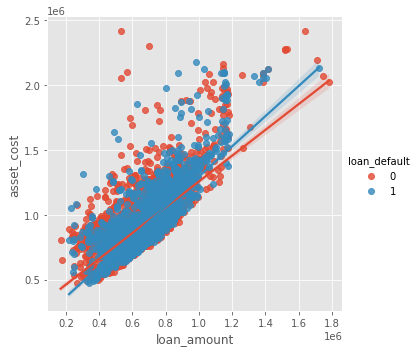

In [25]:
sns.lmplot(data=eda_df,x='loan_amount',y='asset_cost',hue='loan_default')

This Regression plot shows that the regresion lies of both defaulters and non-defaulters are nearly the same with some difference in the slope. 

The relationship between two categorical variables on the target variable can be found by two way ANOVA test

In [26]:
px.scatter(data_frame=train_df,x='age',y='loan_amount',color='loan_default')

In [27]:
model = ols(
    'loan_default ~ C(proof_submitted) + C(last_delinq_none) +\
    C(proof_submitted):C(last_delinq_none)', data=eda_df).fit()
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(proof_submitted),4.0,6.057608,1.514402,6.328431,0.000044
C(last_delinq_none),1.0,0.385026,0.385026,1.608959,0.204680
C(proof_submitted):C(last_delinq_none),4.0,0.748436,0.187109,0.781897,0.536747
Residual,6991.0,1672.955590,0.239301,NaN,NaN


The ANOVA test tells me that the last_delinq_none has more effect on the target variable and the combined effect of both the categorical variables are affecting the result of the target variable. (See the P-Value)

# Feature Selection

<AxesSubplot:>

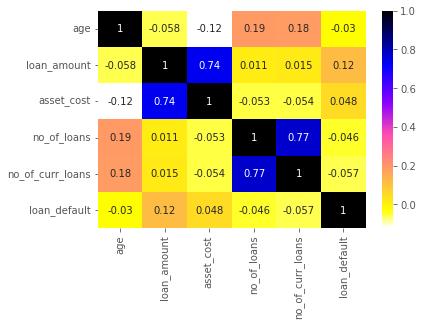

In [28]:
sns.heatmap(train_df[['age','loan_amount','asset_cost','no_of_loans','no_of_curr_loans','loan_default']].corr(),annot=True,cmap='gnuplot2_r')

The above heatmap shows that loan_amount - asset_cost & no_of_loans-no_of_curr_loans are highly correlated to each other making the data redundant. If I were to implement a model with all the data, it would increase the model complexity and it would also certainly take more processing power. 

This violates the assumption of Machine Learning models(i.e,All features are independent of each other).

According to the Dimensionality Reduction rule, Only the Feature that has lower correlation with target variable is to be selected for further analysis.

This can also be verified by using VIF(Variance Inflation Factor)

The value for VIF starts at 1 and has no upper limit. A general rule of thumb for interpreting VIFs is as follows:

1. A value of 1 indicates there is no correlation between a given explanatory variable and any other explanatory variables in the model.
2. A value between 1 and 5 indicates moderate correlation between a given explanatory variable and other explanatory variables in the model, but this is often not severe enough to require attention.
3. A value greater than 5 indicates potentially severe correlation between a given explanatory variable and other explanatory variables in the model. In this case, the coefficient estimates and p-values in the regression output are likely unreliable.

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

numerical_cols = ['age','education','loan_amount','asset_cost','no_of_loans','no_of_curr_loans','last_delinq_none']

vif_data = pd.DataFrame()
vif_data["feature"] = numerical_cols
vif_data['vif'] = [variance_inflation_factor(train_df[numerical_cols].values, i)
                          for i in range(len(numerical_cols))]
vif_data

,feature,vif
0,age,14.935269
1,education,8.171682
2,loan_amount,42.786844
3,asset_cost,40.318453
4,no_of_loans,3.201693
5,no_of_curr_loans,3.576436
6,last_delinq_none,1.097439


In [30]:
numerical_cols = ['education','loan_amount','no_of_loans','no_of_curr_loans','last_delinq_none']

vif_data = pd.DataFrame()
vif_data["feature"] = numerical_cols
vif_data['vif'] = [variance_inflation_factor(train_df[numerical_cols].values, i)
                          for i in range(len(numerical_cols))]
vif_data

,feature,vif
0,education,5.978752
1,loan_amount,6.114654
2,no_of_loans,3.188195
3,no_of_curr_loans,3.547199
4,last_delinq_none,1.097221


By removing age and asset cost, the VIF of the remaining variables are reduced and by doing so, we can reduce the complexity of the model.

Just like it showed in the correlation matrix, even in VIF it is shown that asset_cost and loan_amount are highly correlated. There are other methods of selection features as well.

In [31]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

forward_feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
           k_features=3,
           forward=True,
           verbose=2,
           scoring='roc_auc',
           cv=4)
fselector = forward_feature_selector.fit(train_df[numerical_cols],train_df['loan_default'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.7s finished

[2022-07-26 09:32:41] Features: 1/3 -- score: 0.5359761904761905[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.6s finished

[2022-07-26 09:32:50] Features: 2/3 -- score: 0.533104761904762[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.4s finished

[2022-07-26 09:32:56] Features: 3/3 -- score: 0.5292996598639454

In [32]:
fselector.k_feature_names_

('loan_amount', 'no_of_curr_loans', 'last_delinq_none')

Keeping Aside all these things, I will first try to build a model based on all the parameters and I'll filter out the features after building the model.

# Encoding Categorical Variables and Normalizing numeric Columns

In [33]:
train_df.sample()

,loan_id,age,education,proof_submitted,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,loan_default,age_categorical,loan_amount_cat,asset_cost_cat,no_of_loans_cat,no_of_curr_loans_cat
2261,2262,32,2,Aadhar,651108,1163400,3,0,0,0,"(29.0, 36.0]","(620436.0, 657108.0]","(1147299.0, 2419200.0]","(2.0, 3.0]","(-0.001, 2.0]"


In [34]:
categorical_cols = ['proof_submitted']
numerical_cols = ['age','education','loan_amount','asset_cost','no_of_loans','no_of_curr_loans','last_delinq_none']

encoded_cols = pd.get_dummies(train_df[categorical_cols]).columns
input_cols = list(numerical_cols) + list(encoded_cols)

def encode_and_normalize(dataframe):
    dataframe = impute_missing(dataframe)
    dataframe[encoded_cols] = pd.get_dummies(train_df[categorical_cols])
    return dataframe

In [35]:
encode_and_normalize(train_df).sample(5)

,loan_id,age,education,proof_submitted,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,loan_default,age_categorical,loan_amount_cat,asset_cost_cat,no_of_loans_cat,no_of_curr_loans_cat,proof_submitted_Aadhar,proof_submitted_Driving,proof_submitted_PAN,proof_submitted_Passport,proof_submitted_VoterID
5989,5990,44,1,Aadhar,720756,819600,12,5,0,0,"(43.0, 50.0]","(693108.0, 737364.0]","(797901.0, 826951.5]","(7.0, 109.0]","(4.0, 33.0]",1,0,0,0,0
5370,5371,24,0,Aadhar,651636,959532,0,0,0,0,"(20.999, 29.0]","(620436.0, 657108.0]","(957675.0, 1147299.0]","(-0.001, 2.0]","(-0.001, 2.0]",1,0,0,0,0
892,893,44,2,Aadhar,654000,798000,2,0,0,1,"(43.0, 50.0]","(620436.0, 657108.0]","(797901.0, 826951.5]","(-0.001, 2.0]","(-0.001, 2.0]",1,0,0,0,0
4002,4003,43,1,Aadhar,607236,918912,4,0,0,1,"(36.0, 43.0]","(577788.0, 620436.0]","(900000.0, 957675.0]","(3.0, 7.0]","(-0.001, 2.0]",1,0,0,0,0
4093,4094,41,2,Aadhar,614436,800928,0,0,0,0,"(36.0, 43.0]","(577788.0, 620436.0]","(797901.0, 826951.5]","(-0.001, 2.0]","(-0.001, 2.0]",1,0,0,0,0


# Building the Logistic Regression Model

In [36]:
train_x,test_x,train_y,test_y = train_test_split(train_df[input_cols],train_df['loan_default'])

In [37]:
lr = LogisticRegression(solver='liblinear',class_weight='balanced')
lr.fit(train_x,train_y)
accuracy_score(train_y,lr.predict(train_x))

0.5297142857142857

In [38]:
report = classification_report(test_y,lr.predict(test_x))
print(report)
confusion_matrix(test_y,lr.predict(test_x))

              precision    recall  f1-score   support

           0       0.67      0.45      0.54      1067
           1       0.43      0.65      0.52       683

    accuracy                           0.53      1750
   macro avg       0.55      0.55      0.53      1750
weighted avg       0.57      0.53      0.53      1750



array([[480, 587],
       [240, 443]])

As the report suggests, the model is performing to it's worst even when all the features are used. 

Since Logistic Regression Model has given worst results, I have decided to use Random Forest Classifier Model instead.

## Building a Random Forest Classifier Model

In [39]:
rf = RandomForestClassifier(random_state=42,n_jobs=-1)
rf.fit(train_x,train_y)
accuracy_score(train_y,rf.predict(train_x))

0.9998095238095238

In [40]:
report = classification_report(test_y,rf.predict(test_x))
print(report)
confusion_matrix(test_y,rf.predict(test_x)),accuracy_score(test_y,rf.predict(test_x))

              precision    recall  f1-score   support

           0       0.63      0.75      0.68      1067
           1       0.44      0.31      0.36       683

    accuracy                           0.58      1750
   macro avg       0.54      0.53      0.52      1750
weighted avg       0.56      0.58      0.56      1750



(array([[800, 267],
        [472, 211]]),
 0.5777142857142857)

Eventhough the model is performing better on the training data, it is not performing that well on the test data. This is due to Overfitting. We must tune hyperparameters of Random Forest Model so that the overfitting is avoided and more generalization is achieved.

### Tuning HyperParameters

In [41]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_x, train_y)
    train_accuracy = accuracy_score(model.predict(train_x), train_y)
    test_accuracy = accuracy_score(model.predict(test_x), test_y)
    return train_accuracy, test_accuracy
def test_param_and_plot(param_name, param_values):
    train_accuracies, test_accuracies = [],[]
    for value in param_values:
        params = {param_name: value}
        train_accuracy, test_accuracy = test_params(**params)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_accuracies, 'b-o')
    plt.plot(param_values, test_accuracies, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])

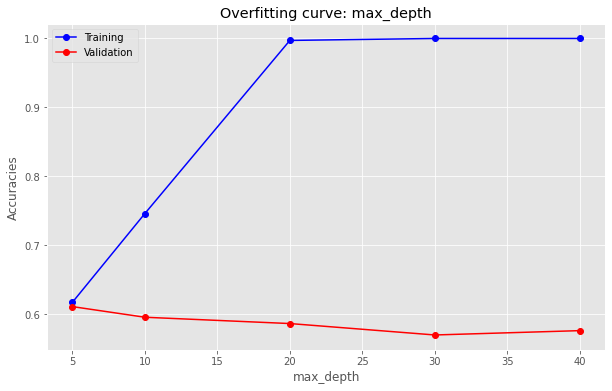

In [42]:
test_param_and_plot('max_depth',[5,10,20,30,40])

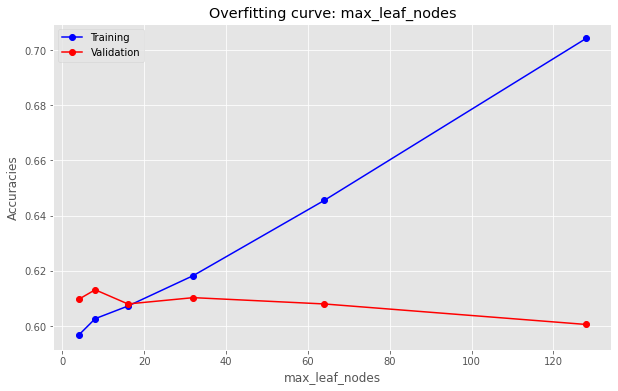

In [43]:
test_param_and_plot('max_leaf_nodes',[4,8,16,32,64,128])

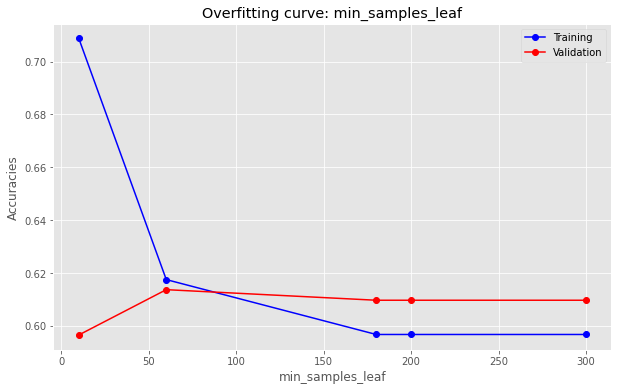

In [44]:
test_param_and_plot('min_samples_leaf',[10,60,180,200,300])

In [45]:
from sklearn.model_selection import RandomizedSearchCV
params = {
    'max_depth':[5,10,20,30],
    'max_leaf_nodes':[16,32,64,128],
    'min_samples_leaf':[10,20,30,40,60,80]
}
final_model = RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1,random_state=42,
                                                                 class_weight='balanced'),
                                param_distributions=params,
                                 n_jobs = -1,
                                 random_state=42,
                                 scoring='roc_auc'
                                )
final_model.fit(train_x,train_y)

RandomizedSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20, 30],
                                        'max_leaf_nodes': [16, 32, 64, 128],
                                        'min_samples_leaf': [10, 20, 30, 40, 60,
                                                             80]},
                   random_state=42, scoring='roc_auc')

In [46]:
final_model.best_params_

{'min_samples_leaf': 80, 'max_leaf_nodes': 16, 'max_depth': 30}

In [47]:
train_preds = final_model.predict(test_x)
print(classification_report(test_y,final_model.predict(test_x)))

              precision    recall  f1-score   support

           0       0.68      0.57      0.62      1067
           1       0.46      0.57      0.51       683

    accuracy                           0.57      1750
   macro avg       0.57      0.57      0.57      1750
weighted avg       0.59      0.57      0.58      1750



In [48]:
confusion_matrix(test_y,final_model.predict(test_x))

array([[613, 454],
       [292, 391]])

In [49]:
pd.DataFrame(final_model.predict(test_x)).value_counts()

0    905
1    845
dtype: int64

### Validating the Model with KFold Cross Validation

In [50]:
mod = RandomForestClassifier(n_jobs=-1,min_samples_leaf= 80, max_leaf_nodes= 16, 
                             max_depth= 30,random_state=42)
kfold = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)
for train_index, test_index in kfold.split(train_df[input_cols],train_df['loan_default']):
    X_train, X_test = train_df.loc[train_index,:], train_df.loc[test_index,:]
    y_train, y_test = train_df.loc[train_index,:]['loan_default'], train_df.loc[test_index,:]['loan_default']
    model = mod
    mod.fit(X_train[input_cols],y_train)
    print("Train acc:",accuracy_score(y_train,mod.predict(X_train[input_cols])),
                                     "\nTest acc:",accuracy_score(y_test,mod.predict(X_test[input_cols])),
                                     "\n-------------------------------------------------")

Train acc: 0.6033928571428572 
Test acc: 0.5978571428571429 
-------------------------------------------------
Train acc: 0.6096428571428572 
Test acc: 0.595 
-------------------------------------------------
Train acc: 0.6041071428571428 
Test acc: 0.6007142857142858 
-------------------------------------------------
Train acc: 0.6067857142857143 
Test acc: 0.6007142857142858 
-------------------------------------------------
Train acc: 0.60375 
Test acc: 0.6092857142857143 
-------------------------------------------------


In [51]:
mod = RandomForestClassifier(n_jobs=-1,min_samples_leaf= 80, max_leaf_nodes= 16, 
                             max_depth= 30,random_state=42)
kfold = KFold(n_splits=5,random_state=42, shuffle=True)
for train_index, test_index in kfold.split(train_df):
    X_train, X_test = train_df.loc[train_index,:], train_df.loc[test_index,:]
    y_train, y_test = train_df.loc[train_index,:]['loan_default'], train_df.loc[test_index,:]['loan_default']
    model = mod
    mod.fit(X_train[input_cols],y_train)
    print("Train acc:",accuracy_score(y_train,mod.predict(X_train[input_cols])),
                                     "\nTest acc:",accuracy_score(y_test,mod.predict(X_test[input_cols])),
                                     "\n-------------------------------------------------")

Train acc: 0.5992857142857143 
Test acc: 0.625 
-------------------------------------------------
Train acc: 0.6080357142857142 
Test acc: 0.6021428571428571 
-------------------------------------------------
Train acc: 0.6094642857142857 
Test acc: 0.5942857142857143 
-------------------------------------------------
Train acc: 0.6066071428571429 
Test acc: 0.605 
-------------------------------------------------
Train acc: 0.6067857142857143 
Test acc: 0.5878571428571429 
-------------------------------------------------


The model is giving a decent train-test Accuracy and this model cannot be improved further since even the best fit model only gives around 60% accuracy.

# Predicting The Outputs for Unknown Data

In [52]:
test_df = encode_and_normalize(test_df)

In [53]:
soln = lr.predict(test_df[input_cols])

In [54]:
output = pd.DataFrame(soln,index=test_df.loan_id,columns=['loan_default'])
output.to_csv('sub.csv',index=True)

In [55]:
output.sample(5)

,loan_default
loan_id,
7254,0
8866,1
9912,1
8208,1
9042,1


# References

1. [4 Types of Classification Tasks in Machine Learning by MachineLearningMastery.com](https://machinelearningmastery.com/types-of-classification-in-machine-learning/)
2. [SMOTE for Imbalanced Classification with Python by MachineLearningMastery.com](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
3. [Failure of Classification Accuracy for Imbalanced Class Distributions](https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/)
4. [How to Perform a Two-Way ANOVA in Python by GeeksForGeeks](https://www.geeksforgeeks.org/how-to-perform-a-two-way-anova-in-python/)
5. [Plotly Documentation](https://plotly.com/python/)
6. [SKlearn Documentation](https://scikit-learn.org/)
7. [Seaborn Documentation](https://seaborn.pydata.org/)
8. [Numpy Documentation](https://numpy.org/doc/)
9. [Pandas Documentation](https://pandas.pydata.org/docs/)

# Future Works
1. I would like to improve this model's performance to it's maximum level.
2. I would also like to build a deep learning model based on Multi Layer Perceptron to increase the accuracy of the predictions.
3. I would also try to do some statistical methods to increase the quality of the data. The methods include SMOTE(Synthetic Minority Oversampling) and Random Undersampling and also a few Dimensionality Reduction techniques.